## Prerequisites

In [1]:
# import Qiskit
from qiskit import IBMQ, QuantumCircuit, Aer, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *

# import api token
apitoken = 'paste your api token here'
try :
    IBMQ.enable_account(token=apitoken)
except:
    pass
provider = IBMQ.get_provider(project='default') 

# Repetition Code

Real quantum computers don't work exactly the way they should (as we expect), because
1. each gate is slightly wrong
2. qubits get poked by small external forces (charge noise, thermal fluctuation, etc.)
3. measurements sometimes lie.
However, quantum algorithms assume that all qubits are perfect and thus we need error corrections.

Repetition code is an ansatz for error correction. 

Before getting started, we first introduce some nouns:
- logical qubits: the (imperfect, or noisy) qubits 
- physical qubits: the perfect qubits required by algorithms

The repetition code is defined by two parameters, $d$: number of repetition `num_repetition` and $T$: number of measurement round `num_measurement_round`.
- $d$ determines how many qubits we need in the code. The actual information are stored in these $d$ qubits (the so-called *code qubits*). That is, if you would like to encode a information `1`, you repeat $d$ times.
- $T$ is the syndrome measurement round that required to extract the information. 
For the repetition code, these are based on the fact that all code qubits should be in the same state (all $\left|0\right>$ or all $\left|1\right>$). 
Any departure from this is therefore a signature of error. Specifically, we imagine our $d$ code qubits sitting along a line. We will then perform a measurement on each pair of neighboring code qubits. This will tell us whether they are the same or different, without extracting any information on what their values are.
- *link qubits*: qubits that required for storing the syndrome measurements, with the number of $d-1$.
By pefforming two CNOTs between the pair of code qubits and a corresponding link qubit, the required information (and only the required information) is placed on the link qubit and can then be measured.

Before applying repetition cede, we need to introduce the noise model, which allows us to get closer to the reality and feel the power of error correction. 

In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import thermal_relaxation_error, depolarizing_error, pauli_error

noise_model = NoiseModel()

t1 = 12
t2 = 11
time = 20
thermal_error = thermal_relaxation_error(t1, t2, time)
noise_model.add_all_qubit_quantum_error(thermal_error, ['u1', 'u2', 'u3', 'id'])

p_cx = 0.07
error_cx = depolarizing_error(p_cx, 1)
error_cx = error_cx.tensor(error_cx)
noise_model.add_quantum_error(error_cx, ['cx'], [1,2])

p_flip = 0.12
error_meas_flip = pauli_error([('X', p_flip), ('I', 1 - p_flip)])
noise_model.add_all_qubit_quantum_error(error_meas_flip, ['measure'])

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'u1', 'id', 'u3', 'measure', 'u2']
  Qubits with noise: [1, 2]
  All-qubits errors: ['u1', 'u2', 'u3', 'id', 'measure']
  Specific qubit errors: [('cx', [1, 2])]


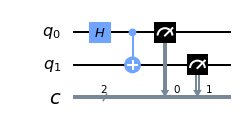

In [3]:
n = 2
bell_circ = QuantumCircuit(n,n)
bell_circ.h(0)
bell_circ.cx(0,1)
bell_circ.measure(range(n), range(n))

bell_circ.draw('mpl', scale=0.5)

Next, do the experiments.

simulator :  {'00': 488, '11': 536}
noisy simulator :  {'01': 111, '00': 399, '10': 101, '11': 413}
ibmq_vigo :  {'01': 22, '00': 480, '10': 20, '11': 502}


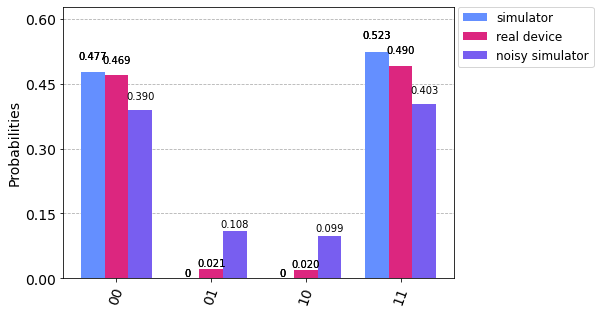

In [4]:
simulator = Aer.get_backend('qasm_simulator')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 5 and 
                                       not x.configuration().simulator and x.status().operational==True))
shots = 1024
# simulator
job_ideal = execute(bell_circ, backend=simulator, shots=shots)
counts_ideal = job_ideal.result().get_counts(bell_circ)
print('simulator', ': ', counts_ideal)
# noise model
job_noisy = execute(bell_circ, backend=simulator, shots=shots, noise_model=noise_model)
counts_noisy = job_noisy.result().get_counts(bell_circ)
print('noisy simulator', ': ', counts_noisy)
# real device
job_qc = execute(bell_circ, backend=backend, shots=shots)
counts_qc = job_qc.result().get_counts(bell_circ)
print(backend, ': ', counts_qc)

from qiskit.visualization import plot_histogram
plot_histogram([counts_ideal, counts_qc, counts_noisy], legend=['simulator', 'real device', 'noisy simulator'])

In [5]:
from qiskit.ignis.verification.topological_codes import RepetitionCode
from qiskit.ignis.verification.topological_codes import GraphDecoder
from qiskit.ignis.verification.topological_codes import lookuptable_decoding, postselection_decoding

num_repetition = 4
num_measurement_round = 2
rep_code = RepetitionCode(num_repetition, num_measurement_round)


for log in ['0', '1']:
    print(f'----------- logical {log} ----------')
    print(rep_code.circuit[log])

----------- logical 0 ----------
                    ┌───┐          ┌───┐          ┌─┐               ┌───┐     »
      link_qubit_0: ┤ X ├──────────┤ X ├──────────┤M├─|0>───────────┤ X ├─────»
                    └─┬─┘┌───┐     └─┬─┘┌───┐     └╥┘ ┌─┐           └─┬─┘┌───┐»
      link_qubit_1: ──┼──┤ X ├───────┼──┤ X ├──────╫──┤M├──|0>────────┼──┤ X ├»
                      │  └─┬─┘┌───┐  │  └─┬─┘┌───┐ ║  └╥┘  ┌─┐        │  └─┬─┘»
      link_qubit_2: ──┼────┼──┤ X ├──┼────┼──┤ X ├─╫───╫───┤M├──|0>───┼────┼──»
                      │    │  └─┬─┘  │    │  └─┬─┘ ║   ║   └╥┘        │    │  »
      code_qubit_0: ──■────┼────┼────┼────┼────┼───╫───╫────╫─────────■────┼──»
                           │    │    │    │    │   ║   ║    ║              │  »
      code_qubit_1: ───────■────┼────■────┼────┼───╫───╫────╫──────────────■──»
                                │         │    │   ║   ║    ║                 »
      code_qubit_2: ────────────■─────────■────┼───╫───╫────╫─────────────────»
       

We want to run both circuits at the once (in order to correct for both `0` and `1` cases). Thus we need to convert them into a list.
Also, we extract the results and convert them into a form easily understood.

In [6]:
rep_circ_raw = rep_code.get_circuit_list()
#circ = []
#for bell_circ in rep_circ_raw:
#    circ.append(bell_circ)


shots = 1024
job_rep_ideal = execute( rep_circ_raw, backend=simulator, shots=shots)
job_rep_noisy = execute( rep_circ_raw, backend=simulator, noise_model=noise_model, shots=shots)

raw_results_ideal = {}
raw_results_noisy = {}
for log in ['0','1']:
    raw_results_ideal[log] = job_rep_ideal.result().get_counts(log)
    raw_results_noisy[log] = job_rep_noisy.result().get_counts(log)
results_rep_ideal = rep_code.process_results(raw_results_ideal)
results_rep_noisy = rep_code.process_results(raw_results_noisy) # not printed here
print(results_rep_ideal)
for log in results_rep_ideal:
    print('\nMost common results for a stored',log)
    for output in results_rep_ideal[log]:
        if results_rep_ideal[log][output]>100:
            print(output,'ocurred for', results_rep_ideal[log][output],'samples.')

{'0': {'0 0  000 000 000': 1024}, '1': {'1 1  000 000 000': 1024}}

Most common results for a stored 0
0 0  000 000 000 ocurred for 1024 samples.

Most common results for a stored 1
1 1  000 000 000 ocurred for 1024 samples.


### How to read the results?

*Note*: $d$ is the number of repetitioin and $T$ is the number of measurement round.

- The 0 0 to the far left for the logical 0 result, and the 1 1 to the far left of the logical 1, are the logical readout. Any code qubit could be used for this readout, since they should (without errors) all be equal. So we could have just one result here, for one arbitrarily chosen code qubit. Or we could have $d$, one for each qubit. Instead we have two, from the two qubits at either end of the line. This is because it works best with the decoder (which we'll use later). In the absence of errors, these two values will always be equal.

- The following 0000 is the $d-1$ results of the syndrome measurements for the first round.A 0 implies that the corresponding pair of qubits where the same, and 1 implies different. There are $d-1$ results because the line of $d$ code qubits has $d-1$ possible neighboring pairs. In the absence of errors, they will all be 0.

- The 0000 that follows that is the syndrome change between the first and second rounds. It is therefore the bitwise OR of the syndrome measurement results from the second round with those from the first. In the absence of errors, they will all be 0.

- Subsequent blocks follow the same formula, though the last requires some comment. This is not measured using the standard method (with a link qubit). Instead it is calculated from the final readout measurement of all code qubits. Again it is presented as a syndrome change, and will be all 0 in the absence of errors. This is the $T+1$-th block of syndrome measurements since, as it is not done in the same way as the others, it is not counted among the $T$ syndrome measurement rounds.


**Example 1**: 0 0  0110 0000 0000 would represent a `num_repetition=5`, `num_measurement_round=2` repetition code with encoded 0. The syndrome shows that (most likely) the middle code qubit was flipped by an error before the first measurement round. This causes it to disagree with both neighboring code qubits for the rest of the circuit. This is shown by the syndrome in the first round, but the blocks for subsequent rounds do not report it as it no longer represents a change. Other sets of errors could also have caused this syndrome, but they would need to be more complex and so presumably less likely.

**Example 2**: 0 0  0010 0010 0000 would represent a `num_repetition=5`, `num_measurement_round=2` repetition code with encoded 0. Here one of the syndrome measurements reported a difference between two code qubits in the first round, leading to a 1. The next round did not see the same effect, and so resulted in a 0. However, since this disagreed with the previous result for the same syndrome measurement, and since we track syndrome changes, this change results in another 1. Subsequent rounds also do not detect anything, but this no longer represents a change and hence results in a 0 in the same position. Most likely the measurement result leading to the first 1 was an error.

**Example 3**: 0 1  0000 0001 0000 would represent a `num_repetition=5`, `num_measurement_round=2` repetition code with encoded 1. A code qubit on the end of the line is flipped before the second round of syndrome measurements. This is detected by only a single syndrome measurement, because it is on the end of the line. For the same reason, it also disturbs one of the logical readouts.

Note that in all these examples, a single error causes exactly two characters in the string to change from the value it would have with no errors. This is, in fact, the reason why the logical output consists of both endpoints. It is a property that will be used by the decoder.

## Probability of a logical error

In [7]:
decoder = GraphDecoder(rep_code)

decoder_ideal = decoder.get_logical_prob(results_rep_ideal)
decoder_noisy = decoder.get_logical_prob(results_rep_noisy)
print('ideal: ', decoder_ideal)
print('noise model: ', decoder_noisy)

ideal:  {'0': 0.0, '1': 0.0}
noise model:  {'0': 0.05078125, '1': 0.0458984375}


# Reference

Further reading, please visit [Qiskit textbook](https://qiskit.org/textbook/ch-quantum-hardware/error-correction-repetition-code.html).

In [8]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

# Exercise

Do the repetition code on your favorite real device (or you may want to build up a noisy simulator, that will be okay).
In addition to run a repetition code, please append a simple quantum circuit, such as an entangled state generator or a others, before the code. Compare the results with different parameters set (number of repetition and the number of measurement round).